# <b><u> Project Title - FreeCharge Classification of Transactions</u></b>

##### **Project Type**    - Supervised (Classification, Natural Language Programming)
##### **Contribution** - Individual

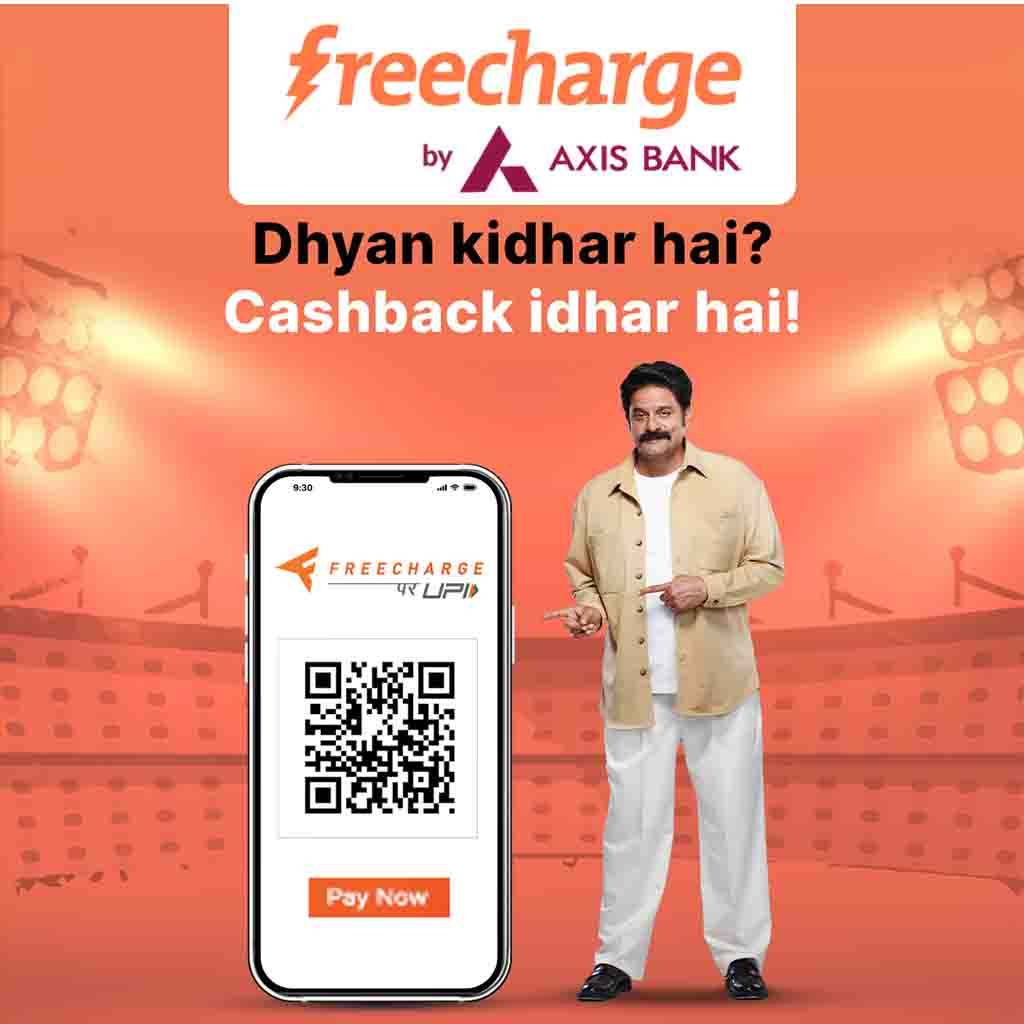

# **GitHub Link**
https://github.com/Jayeshdahiwale/data_for_categorization

# **Project Summary**

This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

In this project, we worked on a text clustering problem where we had to classify/group the Netflix movie/shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other.

- The dataset contained about 7787 records, and 11 attributes.

- We began by dealing with the dataset's missing values and doing exploratory data analysis (EDA).

- Creating cluster using following attributes: director, cast, country, genre, rating and description. The values in these attributes were tokenized, preprocessed, and then vectorized using TFIDF vectorizer.

- We used Principal Component Analysis (PCA) to handle the curse of dimensionality.

- We built Two types of clusters using the K-Means Clustering and Agglomerative Heirachycal clustering algorithm and find out optimal number of clusters using diffrent technique such as elbow method, silhoutte score and dendogram etc.

- A content based recommender system was built using the similarity matrix obtained after using cosine similarity. This recommender system will make 10 recommendations to the user based on the type of show they watched.

# **Index**
1. Problem Statement
2. Importing the Libraries and the Dataset
3. Understanding Data
4. Data Cleaning
4. Exploratory Data Analysis
6. Textual Data Preprocessing
7. Classifier Model Building
8. Bert Model Implementation
9. Conclusions

In [123]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install rapidfuzz
!pip install wordcloud
!pip install Augmentor
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [124]:
# importing general libraries
import openpyxl as xl
from openpyxl.styles import numbers
import concurrent
import concurrent.futures
import time

#import visualzation and array generaring libraies
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Importing textual preprocessing libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import nltk
from rapidfuzz import fuzz


#importing data preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import model selection libraries
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV

#import classification algorithms
from transformers import DistilBertTokenizer,TFDistilBertForSequenceClassification, TextClassificationPipeline,TFTrainer,TFTrainingArguments
import tensorflow as tf
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

#importing metrics for model evaluation
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score,recall_score,f1_score,roc_auc_score,roc_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


In [125]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Reading the Dataset**

In [126]:
# Load the Excel file

wb = xl.load_workbook('/content/drive/MyDrive/data/Final_train_prep.xlsx')  # Replace 'your_file.xlsx' with the actual file name

# Select the sheet
sheet = wb['Sheet1']  # Replace 'Sheet1' with the actual sheet name
date_format = 'dd/mm/yyyy'
# Iterate through the rows and columns
for row in sheet.iter_rows():
  cell = row[1]
  # Apply the desired date format
  cell.number_format = date_format  # Replace with the desired date format

# Save the modified Excel file
wb.save('formatted_file.xlsx')  # Replace 'formatted_file.xlsx' with the desired file name


In [127]:
data = pd.read_excel('formatted_file.xlsx')

In [128]:

test_input = data.iloc[1,:].values

In [129]:
# Extracting the date from the timestamp
data['Date'] = data['Date'].apply(lambda x: str(x).split(' ')[0])

In [130]:
data.head(1)

,Sl. No.,Date,Cheque No.,Description,Sub-Category,Category,Amount,Category.1,Balance
0,12.0,2021-09-16,NaN,TO TRANSFER-UPI/DR/125990176674/HOTEL AK/UTIB/...,Accomodations,Travel,-786.0,Transfer to GPAY-11182,22340.36


<Axes: >

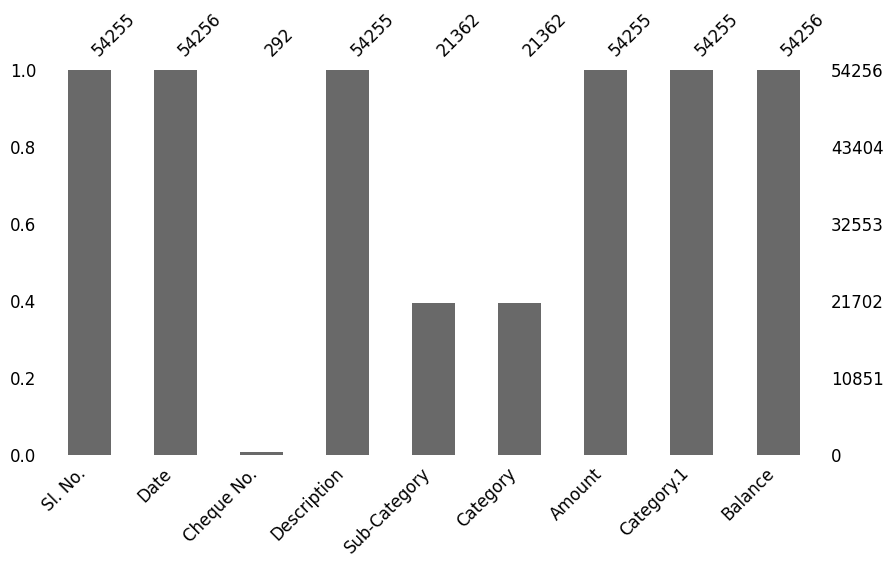

In [131]:
# visualisingb the missing values
import missingno as msno
msno.bar(data,figsize=(10,5),fontsize=12)


In [132]:
# Lets check all column's null values percentage wise
data.isna().sum() * 100/len(data)

Sl. No.          0.001843
Date             0.000000
Cheque No.      99.461811
Description      0.001843
Sub-Category    60.627396
Category        60.627396
Amount           0.001843
Category.1       0.001843
Balance          0.000000
dtype: float64

In [133]:
# dropping SL no and Cheque No. columns
data.drop(['Cheque No.','Sl. No.'], axis= 1, inplace = True)

In [134]:
#lets check total number of duplicated rows
duplicate_rows = data.duplicated().sum()
print(f"Total number of duplcated rows are {duplicate_rows}")

Total number of duplcated rows are 570


In [135]:
# There is one row in description which is null. Lets remove the observation where descirption is null.Description is very important in this project
# drop dupllicate rows
data.dropna(subset=['Description'], inplace=True)
data.drop_duplicates(inplace=True)

-We will use two textual columns as independent variable . One is "Description" and another one is "Category.1"
- We will need both of them in model prediction so lets merge both the columns

In [136]:
data['Desc_Cat'] = data['Description'].apply(lambda x: str(x)) + " " +  data['Category.1'].apply(lambda x: str(x))

In [137]:
data

,Date,Description,Sub-Category,Category,Amount,Category.1,Balance,Desc_Cat
0,2021-09-16,TO TRANSFER-UPI/DR/125990176674/HOTEL AK/UTIB/...,Accomodations,Travel,-786.0,Transfer to GPAY-11182,22340.36,TO TRANSFER-UPI/DR/125990176674/HOTEL AK/UTIB/...
1,2021-10-08,TO TRANSFER-UPI/DR/128188085567/HOTEL AK/UTIB/...,Accomodations,Travel,-1321.0,Transfer to GPAY-11182,12066.36,TO TRANSFER-UPI/DR/128188085567/HOTEL AK/UTIB/...
3,2021-02-06,UPI/P2M/103840249705/Hotel Gra/Yes Bank /NA,Accomodations,Travel,-1100.0,Transfer to Hotel Gra,54.48,UPI/P2M/103840249705/Hotel Gra/Yes Bank /NA Tr...
4,2021-01-23,UPI/P2M/102321272114/Hotel Shw/Axis Bank/UPI,Accomodations,Travel,-440.0,Transfer to Hotel Shw,2519.28,UPI/P2M/102321272114/Hotel Shw/Axis Bank/UPI T...
5,2021-02-06,UPI/P2M/103839957032/Oyo Rooms/HDFC BANK/OYORoom,Accomodations,Travel,-847.0,Transfer to Oyo Rooms,1154.48,UPI/P2M/103839957032/Oyo Rooms/HDFC BANK/OYORo...
...,...,...,...,...,...,...,...,...
54251,2022-02-05,NACH-10-DR-INCRED FINANCIAL SER -INCRED78CVSDJ...,NaN,NaN,-4119.0,Loan,15950.11,NACH-10-DR-INCRED FINANCIAL SER -INCRED78CVSDJ...
54252,2022-02-05,UPI/HARI PRADHAN D/203640954009/Payment from P...,NaN,NaN,-15000.0,Transfer to HARI PRADHAN D,950.11,UPI/HARI PRADHAN D/203640954009/Payment from P...
54253,2022-02-06,UPI/KOSANA RAJASEKH/203755167677/UPI (Ref# UPI...,NaN,NaN,3000.0,Transfer from KOSANA RAJASEKH,3950.11,UPI/KOSANA RAJASEKH/203755167677/UPI (Ref# UPI...
54254,2022-02-07,UPI/Electricity Boa/203852514873/Oid1724063818...,NaN,NaN,-591.0,Utilities,3359.11,UPI/Electricity Boa/203852514873/Oid1724063818...


- We observer that 60% of the target variables 'Categories' and 'Subcategories' are missing which is huge data.
- Removing those rows will lead to loss of informational data
- Below I have defined a metric to resolve this issue by Description similarity using library **"RapidFuzz"**

## There are in total 54000 rows approx.  So to deal with 60% missing Target variables :
1) First filtered the data which has Category and SubCategories are not null

2) Filter out data which has Category null and SubCategory null

3) Our goal is to iterate over every rows of null having Category valye missing, and comparing its **description** value with all rows with **Category** value being not null and find out **fuzz ratio**

-- Note : For fuzz ratio I have used **RapidFuzz** library

4) Whichever row match has highest fuzz score , its Category and SubCategory will be allotted to that given row.

5) **Time complxity for this task is 0(n^3)**, because finding fuzz ration after iterating is also computationally expensive.

6) To tackle this issue , I have created total **61 threads(max thread capacity)**, divided the null data into **61 chunks**. I allot **1 chunk to 1 thread** to work upon. It reduces the total time required by **61 folds**

7) Time requiere to complete this process : **15 minute** using 61 threads running parallelly

8) Without using threads : 15 * 61 = 915 minutes = **~15 hours**

In [138]:
start_time = time.time()

non_null_data = [data[data['Category'].notnull() & data['Sub-Category'].notnull()] for i in range(61)]


def get_index(null_desc,index):
    non_null_data[index]['fuzz_ratio'] = non_null_data[index]['Desc_Cat'].apply(lambda x: fuzz.ratio(str(x), str(null_desc)))
    return non_null_data[index]['fuzz_ratio'].idxmax()


def preprocess_null_data(chunk,i):
    # Preprocess non-null descriptions by calculating and storing fuzzy scores
    chunk['Index'] = chunk['Desc_Cat'].apply(get_index,index=i)
    return null_data
# Select rows with null Category and Subcategory
null_data = data[data['Category'].isnull() & data['Sub-Category'].isnull()]
# Preprocess the non-null data to calculate and store fuzzy scores
#split
num_batches = 61
# Define the number of parts
num_parts = 61

# Calculate the number of rows per part
rows_per_part = len(null_data) // num_parts

#remaing rows element
rem_ele = len(null_data)% num_parts

# Store the parts in a list
chunks = []


for i in range(num_parts):
    if i == num_parts - 1:
        start_index = i * rows_per_part
        end_index = start_index + rows_per_part + rem_ele
    else:
        start_index = i * rows_per_part
        end_index = start_index + rows_per_part

    part = null_data.iloc[start_index:end_index]
    chunks.append(part)



with concurrent.futures.ThreadPoolExecutor(max_workers=num_batches) as executor:
    # Submit tasks to the executor and store the running tasks
    running_tasks = [executor.submit(preprocess_null_data, chunk,i) for i,chunk in enumerate(chunks)]

    # Retrieve results as they complete
    results = []
    for completed_task in concurrent.futures.as_completed(running_tasks):
        batch_updated = completed_task.result()
        results.append(batch_updated)
end_time = time.time()
print(end_time - start_time)

950.5504183769226


### These chunks actually stores the index of the description from the rows which have non-null Category and SubCategory Values.
### These index are calculated using RapidFuzz library which actually tries to see the similarity in those strings.

In [139]:
#lets view some chunks
chunks[0].head()

,Date,Description,Sub-Category,Category,Amount,Category.1,Balance,Desc_Cat,Index
21362,2021-08-05,ACH D- KOTAKMAHPRIMELTKKBK-RC4-57453718 (Ref# ...,NaN,NaN,-4310.0,Auto Loan,64907.61,ACH D- KOTAKMAHPRIMELTKKBK-RC4-57453718 (Ref# ...,7987
21363,2021-09-05,ACH D- KOTAKMAHPRIMELTKKBK-RC4-58147261 (Ref# ...,NaN,NaN,-4310.0,Auto Loan,59927.61,ACH D- KOTAKMAHPRIMELTKKBK-RC4-58147261 (Ref# ...,7987
21364,2021-10-05,ACH D- KOTAKMAHPRIMELTKKBK-RC4-58796825 (Ref# ...,NaN,NaN,-4310.0,Auto Loan,7302.61,ACH D- KOTAKMAHPRIMELTKKBK-RC4-58796825 (Ref# ...,7987
21365,2021-11-05,ACH D- KOTAKMAHPRIMELTKKBK-RC4-59474535 (Ref# ...,NaN,NaN,-4310.0,Auto Loan,9360.61,ACH D- KOTAKMAHPRIMELTKKBK-RC4-59474535 (Ref# ...,7987
21366,2021-12-05,ACH D- KOTAKMAHPRIMELTKKBK-RC4-60094876 (Ref# ...,NaN,NaN,-4310.0,Auto Loan,4380.61,ACH D- KOTAKMAHPRIMELTKKBK-RC4-60094876 (Ref# ...,7987


In [140]:
chunks[1].head()

,Date,Description,Sub-Category,Category,Amount,Category.1,Balance,Desc_Cat,Index
21892,2021-08-25,ATW-652166XXXXXX7387-S1ANDK01-DHENKANAL,NaN,NaN,-10000.0,Cash Withdrawal,-40000.00,ATW-652166XXXXXX7387-S1ANDK01-DHENKANAL Cash W...,20530
21893,2021-08-25,ATW-652166XXXXXX7387-S1ANDK01-DHENKANAL,NaN,NaN,-10000.0,Cash Withdrawal,-14481.00,ATW-652166XXXXXX7387-S1ANDK01-DHENKANAL Cash W...,20530
21894,2021-08-25,ATW-652166XXXXXX7387-S1ANDK01-DHENKANAL,NaN,NaN,-4000.0,Cash Withdrawal,22000.36,ATW-652166XXXXXX7387-S1ANDK01-DHENKANAL Cash W...,20530
21895,2021-07-08,NWD-541919XXXXXX1724-70209002-TIRUNELVELI (Ref...,NaN,NaN,-1500.0,Cash Withdrawal,14330.36,NWD-541919XXXXXX1724-70209002-TIRUNELVELI (Ref...,20920
21896,2021-07-11,EAW-541919XXXXXX1724-APCN8910-TIRUNELVELI (Ref...,NaN,NaN,-3000.0,Cash Withdrawal,330.36,EAW-541919XXXXXX1724-APCN8910-TIRUNELVELI (Ref...,20591


In [141]:
#lets assign the category and subcatgories to the rows where category and subcategory was missing

for i in range(len(chunks)):
    data.loc[chunks[i].index.values,['Category','Sub-Category']] = data.loc[chunks[i].Index.values,['Category','Sub-Category']].values


In [142]:
data.isna().sum()

Date            0
Description     0
Sub-Category    0
Category        0
Amount          0
Category.1      0
Balance         0
Desc_Cat        0
dtype: int64

We can see that there are no null values. Our dataset seems completely cleaned.

In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53685 entries, 0 to 54255
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          53685 non-null  object 
 1   Description   53685 non-null  object 
 2   Sub-Category  53685 non-null  object 
 3   Category      53685 non-null  object 
 4   Amount        53685 non-null  float64
 5   Category.1    53685 non-null  object 
 6   Balance       53685 non-null  float64
 7   Desc_Cat      53685 non-null  object 
dtypes: float64(2), object(6)
memory usage: 5.7+ MB


In [144]:
# function for fetching month and year
from datetime import datetime
def fetch_month_year(date):
      date_obj = datetime.strptime(date, '%Y-%m-%d')
      month_name = date_obj.strftime('%B')
      year = date_obj.year
      return month_name,year


In [145]:
# There are some values in dates whose format is not known and they are "########"
data[data['Date']=="########"]

,Date,Description,Sub-Category,Category,Amount,Category.1,Balance,Desc_Cat
29686,########,ATMDEC CHG/19-08-2021/8984+GST,Remittance,Fund Transfer,-29.50,Bank Charges,4096.54,ATMDEC CHG/19-08-2021/8984+GST Bank Charges
29687,########,ATMDEC CHG/19-08-2021/8984+GST,Remittance,Fund Transfer,-29.50,Bank Charges,4067.04,ATMDEC CHG/19-08-2021/8984+GST Bank Charges
29848,########,NFS/S1ACKO79/CASH WDL/07-08-21,Withdrawals,Fund Transfer,-1000.00,Cash Withdrawal,4445.04,NFS/S1ACKO79/CASH WDL/07-08-21 Cash Withdrawal
29849,########,NFS/DKL12321/CASH WDL/19-08-21,Withdrawals,Fund Transfer,-2000.00,Cash Withdrawal,1683.04,NFS/DKL12321/CASH WDL/19-08-21 Cash Withdrawal
29850,########,NFS/CW100187/CASH WDL/19-08-21,Withdrawals,Fund Transfer,-1000.00,Cash Withdrawal,683.04,NFS/CW100187/CASH WDL/19-08-21 Cash Withdrawal
29851,########,NFS/S1GM0181/CASH WDL/20-08-21,Withdrawals,Fund Transfer,-500.00,Cash Withdrawal,183.04,NFS/S1GM0181/CASH WDL/20-08-21 Cash Withdrawal
29852,########,CCW/S1CNQ428/2188777/Cardless Cash WDL/IMB,Withdrawals,Fund Transfer,-900.00,Cash Withdrawal,324.04,CCW/S1CNQ428/2188777/Cardless Cash WDL/IMB Cas...
29853,########,NFS/01015033/CASH WDL/02-09-21,Withdrawals,Fund Transfer,-4000.00,Cash Withdrawal,4126.04,NFS/01015033/CASH WDL/02-09-21 Cash Withdrawal
29854,########,CAM/16911HAR/CASH WDL/11-09-21,Withdrawals,Fund Transfer,-200.00,Cash Withdrawal,1357.86,CAM/16911HAR/CASH WDL/11-09-21 Cash Withdrawal
30206,########,BIL/NEFT/000172889384/Credit Card/MY AXIS BA/U...,cc payments,Payments,-7000.00,Credit Card Payment,8445.04,BIL/NEFT/000172889384/Credit Card/MY AXIS BA/U...


In [146]:
# size of faulty dates
print(f"The size of faulty date, {len(data[data['Date']=='########'])}")

#imputing all such dates by mode of date (Date coming most of the times)

data.loc[data['Date']=='########','Date'] = data["Date"].mode().values[0]

The size of faulty date, 31


In [147]:
# creting two columns month and year using date column
data['month'], data['year'] = zip(*data['Date'].apply(fetch_month_year))

In [148]:
data.head()

,Date,Description,Sub-Category,Category,Amount,Category.1,Balance,Desc_Cat,month,year
0,2021-09-16,TO TRANSFER-UPI/DR/125990176674/HOTEL AK/UTIB/...,Accomodations,Travel,-786.0,Transfer to GPAY-11182,22340.36,TO TRANSFER-UPI/DR/125990176674/HOTEL AK/UTIB/...,September,2021
1,2021-10-08,TO TRANSFER-UPI/DR/128188085567/HOTEL AK/UTIB/...,Accomodations,Travel,-1321.0,Transfer to GPAY-11182,12066.36,TO TRANSFER-UPI/DR/128188085567/HOTEL AK/UTIB/...,October,2021
3,2021-02-06,UPI/P2M/103840249705/Hotel Gra/Yes Bank /NA,Accomodations,Travel,-1100.0,Transfer to Hotel Gra,54.48,UPI/P2M/103840249705/Hotel Gra/Yes Bank /NA Tr...,February,2021
4,2021-01-23,UPI/P2M/102321272114/Hotel Shw/Axis Bank/UPI,Accomodations,Travel,-440.0,Transfer to Hotel Shw,2519.28,UPI/P2M/102321272114/Hotel Shw/Axis Bank/UPI T...,January,2021
5,2021-02-06,UPI/P2M/103839957032/Oyo Rooms/HDFC BANK/OYORoom,Accomodations,Travel,-847.0,Transfer to Oyo Rooms,1154.48,UPI/P2M/103839957032/Oyo Rooms/HDFC BANK/OYORo...,February,2021


In [149]:
data.to_csv('backup.csv')

##  EDA :
### Exploratory Data Analysis (EDA) is the very first step before you can perform any changes to the dataset or develop a statistical model to answer business problems. In other words, the process of EDA contains summarizing, visualizing and getting deeply acquainted with the important traits of a data set.

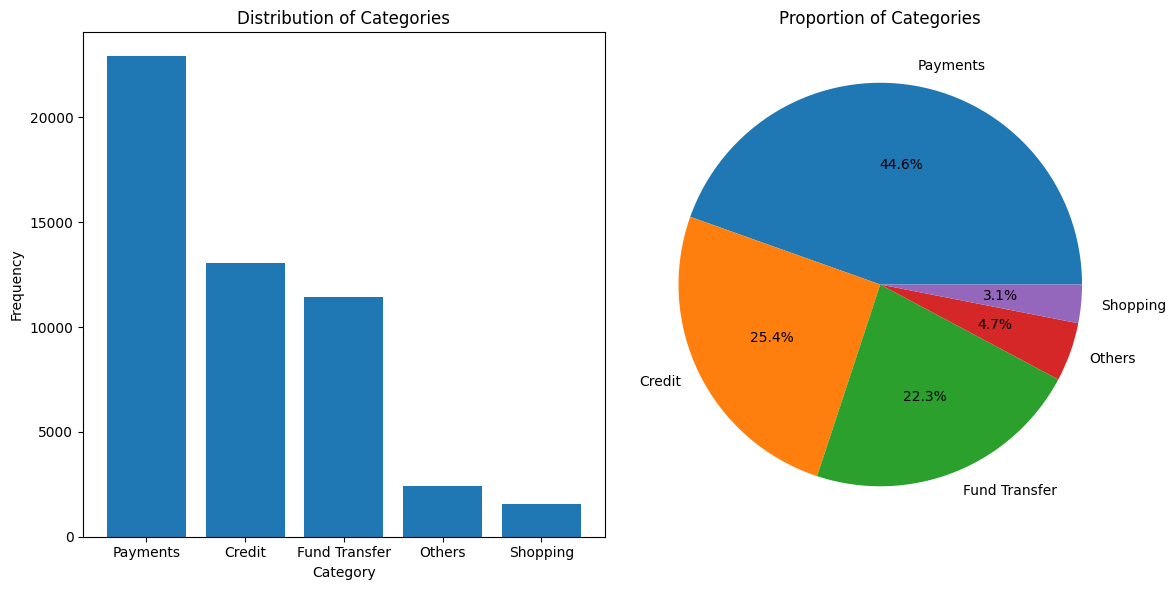

In [150]:
# Calculate the frequency of each category
category_counts = data['Category'].value_counts()[0:5]

# Create subplots with two axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting a bar chart
axes[0].bar(category_counts.index, category_counts.values)
axes[0].set_title('Distribution of Categories')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Frequency')

# Plotting a pie chart
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
axes[1].set_title('Proportion of Categories')
axes[1].set_ylabel('')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

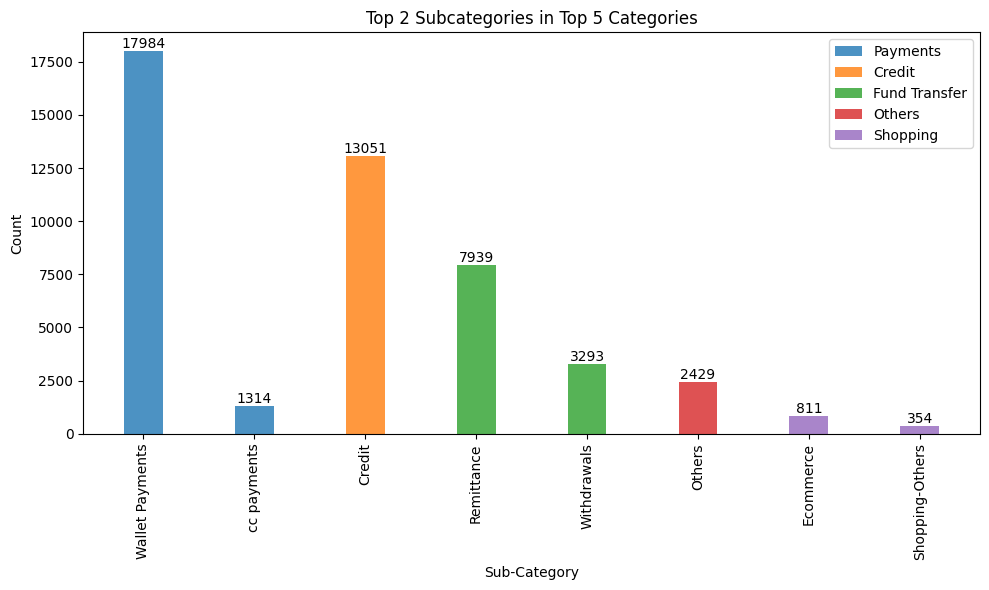

In [151]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch top 5 categories based on value counts
top_categories = data['Category'].value_counts().head(5).index

# Filter the DataFrame to include only the top 5 categories
filtered_data = data[data['Category'].isin(top_categories)]

# Group by 'Category' and 'Sub-Category' and count occurrences
grouped_data = filtered_data.groupby(['Category', 'Sub-Category']).size().reset_index(name='Count')

# Sort the grouped data by 'Category' and 'Count' in descending order
sorted_data = grouped_data.sort_values(by=['Category', 'Count'], ascending=[True, False])

# Retrieve the top 2 subcategories within each category
top_subcategories = sorted_data.groupby('Category').head(2)

# Plotting the top 2 subcategories within each category
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
opacity = 0.8

colors = plt.cm.tab10(range(len(top_categories)))

for i, category in enumerate(top_categories):
    category_data = top_subcategories[top_subcategories['Category'] == category]
    x = category_data['Sub-Category']
    y = category_data['Count']
    ax.bar(x, y, bar_width, alpha=opacity, color=colors[i], label=category)

    # Add labels above each bar with count value
    for xi, yi in zip(x, y):
        ax.text(xi, yi, str(yi), ha='center', va='bottom')

ax.set_xlabel('Sub-Category')
ax.set_ylabel('Count')
ax.set_title('Top 2 Subcategories in Top 5 Categories')
ax.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [152]:
import re
import string
def count_words(sentence):
    delimiters =  re.escape(string.punctuation)
    string_to_split = sentence
    result = re.findall(r'\b(?!\d+\b)\w+\b|' + delimiters, string_to_split)
    result = [s for s in result if not re.match(delimiters, s)]
    return len(result)

In [153]:
data['count'] = data['Desc_Cat'].apply(count_words)

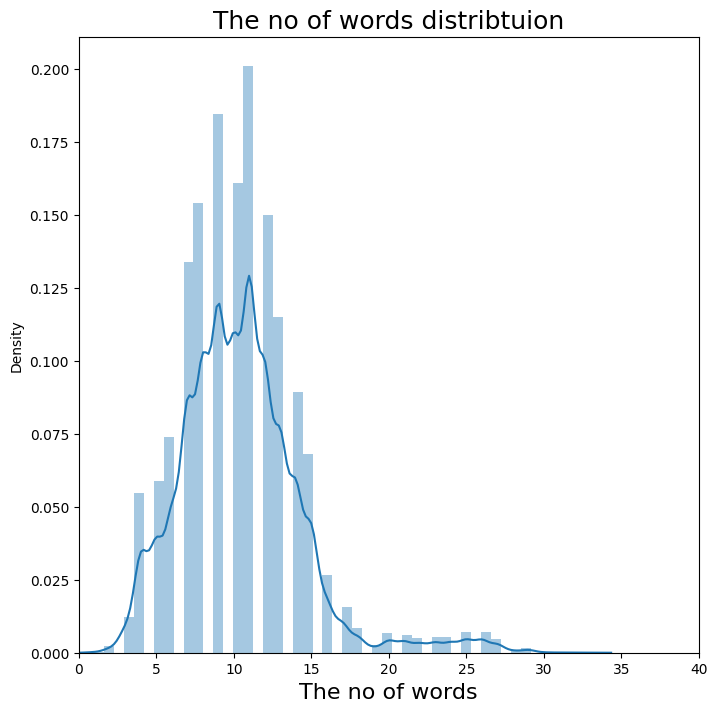

In [154]:
#plotting the distribution plot for no of words in each document
plt.figure(figsize=(8,8))
sns.distplot(data['count'])
plt.xlim(0,40)
plt.xlabel('The no of words', fontsize = 16)
plt.title('The no of words distribtuion', fontsize = 18)
plt.show()

**We can see that most of the Descritpions have number of words range between 5 to 15**


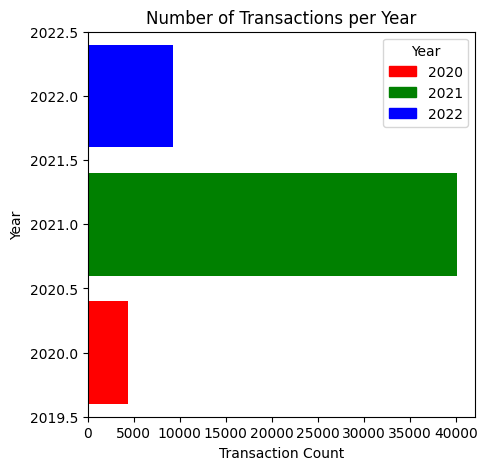

In [155]:

# Get the transaction counts per year
transaction_counts = data['year'].value_counts()

# Sort the transaction counts by year
transaction_counts = transaction_counts.sort_index()

# Create a list of unique years
years = transaction_counts.index

# Create a list of colors for each year
colors = ['red', 'green', 'blue']

# Plot each year's bar with the corresponding color

plt.figure(figsize=(5,5))
for i, year in enumerate(years):
    count = transaction_counts[year]
    plt.barh(year, count, color=colors[i])

# Set the y-axis limits
plt.ylim(min(years)-0.5, max(years)+0.5)

# Set labels and title
plt.xlabel('Transaction Count')
plt.ylabel('Year')
plt.title('Number of Transactions per Year')

# Create a legend with individual bars and colors
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=str(year)) for i, year in enumerate(years)]
plt.legend(handles=legend_handles, title='Year')

plt.show()


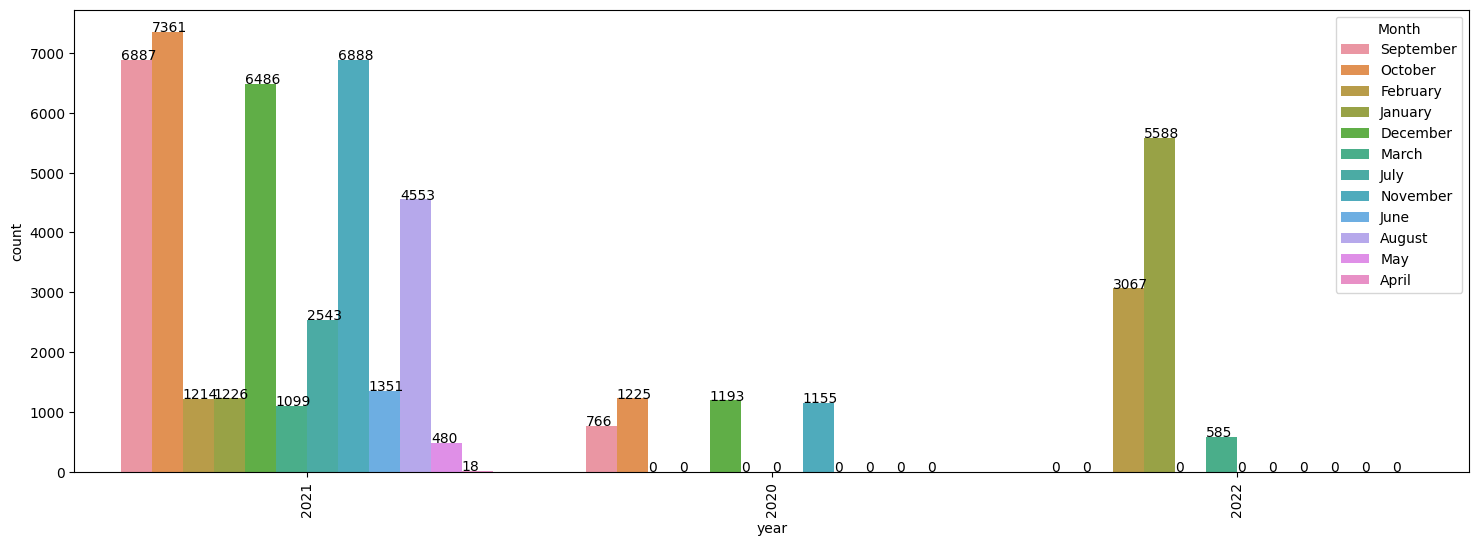

In [156]:
# bivariate analysis
# bivariate analysis
fig,ax = plt.subplots(1,1, figsize=(18,6))
graph = sns.countplot(x="year", data=data, hue='month', order=data['year'].unique(), ax=ax)
plt.xticks(rotation=90)
for p in graph.patches:  #adding value count on the top of bar
   graph.annotate(format(p.get_height(), '.0f'), (p.get_x(), p.get_height()))

plt.legend(title='Month', bbox_to_anchor=(1, 1), loc='upper right')
plt.show()

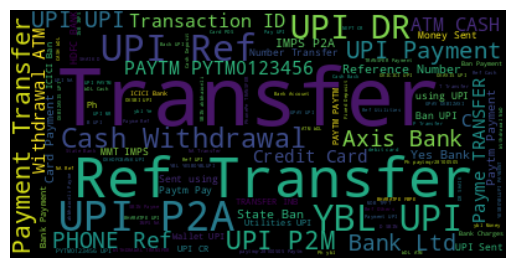

In [157]:
def corpus_maker(column_name):
    delimiters =  re.escape(string.punctuation)
    corpus = data[column_name].apply(lambda x:re.findall(r'\b(?!\d+\b)\w+\b|' + delimiters, x)).values
    return corpus
    #result = [s for s in result if not re.match(delimiters, s)]
# # text documents
text = " ".join(word for sentence in corpus_maker('Desc_Cat') for word in sentence)

# create the word cloud
wordcloud = WordCloud(stopwords=STOPWORDS).generate(text)

# plot the word cloud
plt.imshow(wordcloud,  interpolation='bilinear')
plt.axis("off")
plt.show()


In [158]:
# Lets make a field with Category-Subcategory. Because we are going to use it as our target variable
data['Target'] = data['Category'] + "::" + data['Sub-Category']
data.Target.value_counts()

Payments::Wallet Payments                  17984
Credit::Credit                             13051
Fund Transfer::Remittance                   7939
Fund Transfer::Withdrawals                  3293
Others::Others                              2429
Payments::cc payments                       1314
Payments::Bill/Utility Payments             1248
Payments::Loan Emis                         1240
Shopping::Ecommerce                          811
Payments::Fuel                               590
Food::Food Delivery                          484
Payments::Mobile Bill Payments               470
Investment::Stocks/MF                        409
Shopping::Shopping-Others                    354
Shopping::Groceries & Other Consumables      334
Food::Restaurants                            323
Fund Transfer::P2P                           222
Investment::FD/TD                            193
Entertainment::Gaming                        172
Healthcare::Medicine/Pharma                  142
Travel::Cab/Bike Ser

In [159]:
data['Target'].nunique()

49

In [160]:
model_data = data.copy()

In [161]:
model_data['Encoded_Target'] = data['Target'].astype('category').cat.codes

In [162]:
model_data.head(2)

,Date,Description,Sub-Category,Category,Amount,Category.1,Balance,Desc_Cat,month,year,count,Target,Encoded_Target
0,2021-09-16,TO TRANSFER-UPI/DR/125990176674/HOTEL AK/UTIB/...,Accomodations,Travel,-786.0,Transfer to GPAY-11182,22340.36,TO TRANSFER-UPI/DR/125990176674/HOTEL AK/UTIB/...,September,2021,15,Travel::Accomodations,41
1,2021-10-08,TO TRANSFER-UPI/DR/128188085567/HOTEL AK/UTIB/...,Accomodations,Travel,-1321.0,Transfer to GPAY-11182,12066.36,TO TRANSFER-UPI/DR/128188085567/HOTEL AK/UTIB/...,October,2021,15,Travel::Accomodations,41


In [163]:
#Making a dataframe to see which Target is represented by what code
code_to_label = {}
for code,target in zip(model_data['Encoded_Target'],model_data['Target']):
    if code not in code_to_label:
        code_to_label[code] = target
reference = pd.DataFrame.from_dict(code_to_label, orient='index', columns=['Label'])
reference['Code'] = reference.index
reference = reference.reset_index(drop=True)


In [164]:
reference

,Label,Code
0,Travel::Accomodations,41
1,Travel::Airlines,42
2,Food::Alcohol,7
3,Shopping::Apparel,30
4,Payments::Auto Services,21
5,Payments::Bill/Utility Payments,22
6,Shopping::Books & Stationery,31
7,Travel::Cab/Bike Services,43
8,Travel::Car Rentals,44
9,Payments::cc payments,29


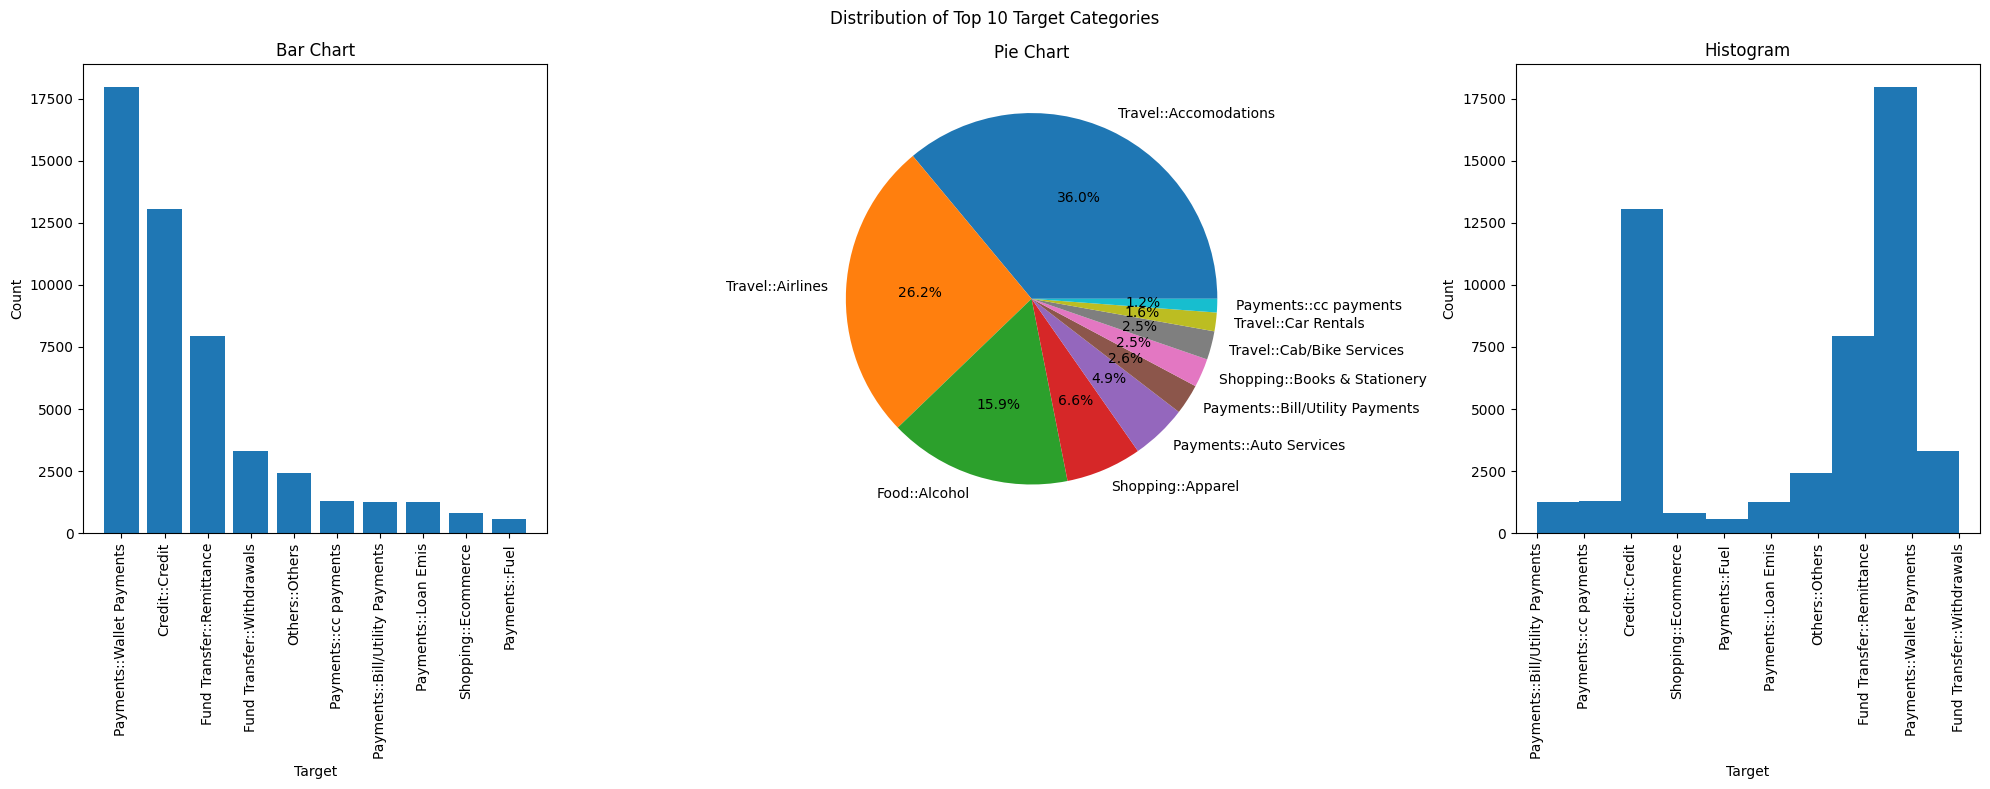

In [165]:
#visualising the bar plot for Target variable

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Bar Chart
axes[0].bar(model_data['Target'].value_counts().index[0:10], model_data['Target'].value_counts().values[0:10])
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Count')
axes[0].set_title('Bar Chart')
axes[0].tick_params(axis='x', rotation=90)
# Pie Chart
axes[1].pie(model_data['Target'].value_counts()[0:10], labels=model_data['Target'].unique()[0:10], autopct='%1.1f%%')
axes[1].set_title('Pie Chart')

# Histogram
top_10_targets = model_data['Target'].value_counts().nlargest(10).index
filtered_data = model_data[model_data['Target'].isin(top_10_targets)]
axes[2].hist(filtered_data['Target'], bins=10)
axes[2].set_xlabel('Target')
axes[2].set_ylabel('Count')
axes[2].set_title('Histogram')
axes[2].tick_params(axis='x', rotation=90)

plt.suptitle('Distribution of Top 10 Target Categories')
# Adjust spacing between subplots
fig.tight_layout()

# Show the plots
plt.show()


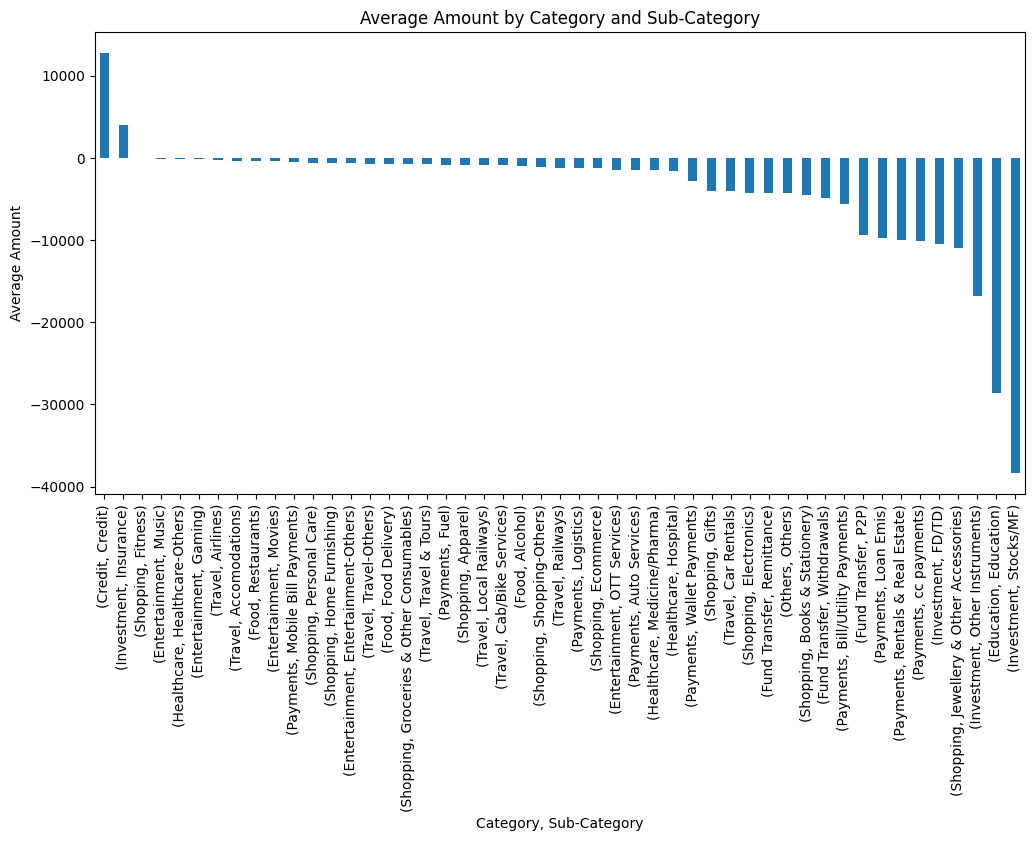

In [166]:
# Group by 'Category' and 'Sub-Category' and calculate the average of 'Amount', then sort in descending order
balance_avg = model_data.groupby(['Category', 'Sub-Category'])['Amount'].mean().sort_values(ascending=False)

# Plot the bar graph
fig, ax = plt.subplots(figsize=(12, 6))
balance_avg.plot.bar(ax=ax)
plt.xticks(rotation=90)  # Rotate x-labels vertically
plt.xlabel('Category, Sub-Category')
plt.ylabel('Average Amount')
plt.title('Average Amount by Category and Sub-Category')
plt.show()

* We can see that the amount of transaction can be a deciding factor for
* For Category **"Education"** and Sub-Category **"Education"** the avergae price of Transaction required is more. Then comes **Investment**sector at **2nd** position.
* We can see that lower **Transaction Prices** mostly for **Shopping and Entertainment Sector**



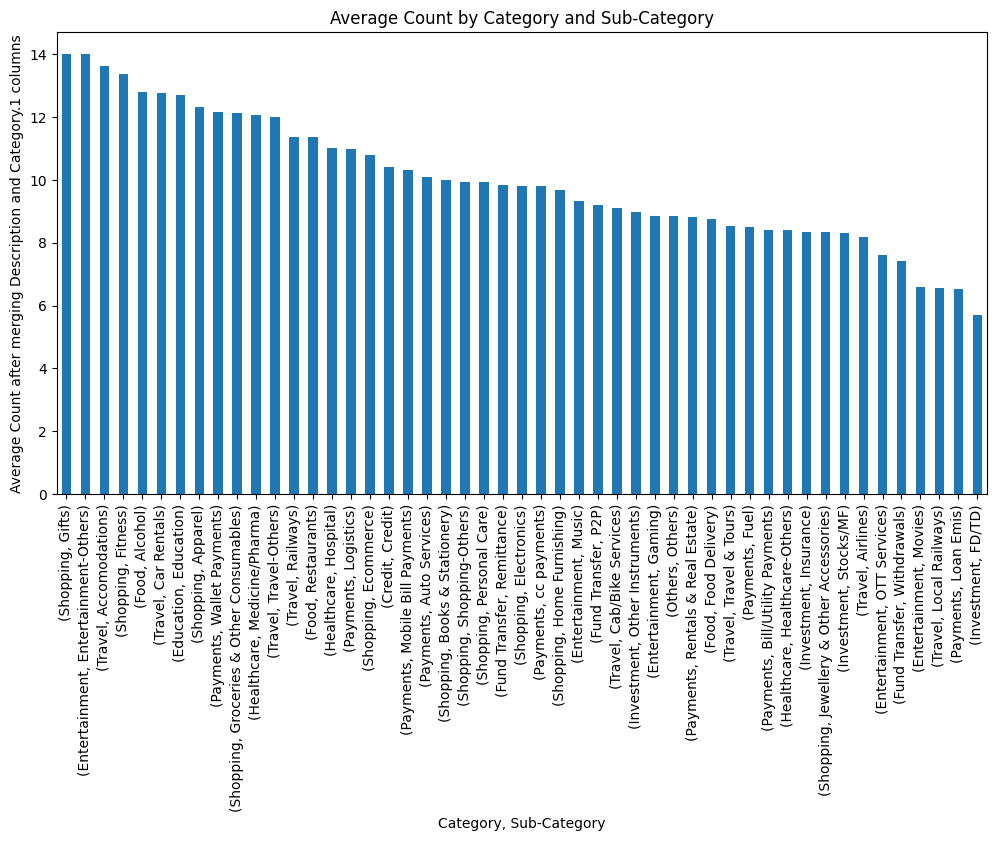

In [167]:
# Group by 'Category' and 'Sub-Category' and calculate the average of 'count', then sort in descending order
balance_avg = model_data.groupby(['Category', 'Sub-Category'])['count'].mean().sort_values(ascending=False)

# Plot the bar graph
fig, ax = plt.subplots(figsize=(12, 6))
balance_avg.plot.bar(ax=ax)
plt.xticks(rotation=90)  # Rotate x-labels vertically
plt.xlabel('Category, Sub-Category')
plt.ylabel('Average Count after merging Description and Category.1 columns')
plt.title('Average Count by Category and Sub-Category')
plt.show()

- Here we can see that the length of script or count of words in the transaction as varies by **"Category-SubCategory"**
- **(Shopping, Gifts)** has **highest average count of words** in description and **(Investment, FD/TD)** has **lowest average count of words**

# Textual Data Preporcessing


**Modeling Approach**
1. Select the attributes based on which you want to build your model
2. Text preprocessing: Remove all stopwords and punctuation marks, convert all textual data to lowercase.
3. Stemming to generate a meaningful word out of corpus of words.
4. Tokenization of corpus and Word vectorization
5. Dimensionality reduction
6. Use different classification algorithms to categorize the observations


#### **6.1. Merging Attributes**
We have already merged the **"description"**  and **"category.1"** as Desc_Cat.

- Desc_Cat [Will be used as Input variable]
- Encode_Target [Will be used as Output Variable]
- We will not need Date Column. Because **Transaction** does't depend on Date. Making Transaction at partcular date could not classify **Transaction**. Instead it will add noise to the data.
- We will not need **Description** and **Category.1** We have already merged these to single column
- We will need the **transaction Amount** column because **transaction amount** varies from **Category to Category**
- We do not need **Balance column**. Because balance in one's person account doesn't decide what kind of transaction he would make in future.
- We will drop **month** and **year** as well.. Because year will keep changing and **year value of future** will also become **out of sight information for the model**
- We will need the **"Count** of words in description because it will also be a deciding factor for **Category** and **SubCategory**.
- We will be dropping **"Target"** column because we need only **"Encoded Target"** for model training

In [168]:
## dropping unwanted columns
model_data.drop(['Date','Description','Sub-Category','Category','Category.1','Balance','month','year','Target'],axis=1,inplace=True)

In [169]:
model_data = model_data.reset_index()

####**Removing Stopwords and Lower Casing.**

Removing stop words and lowercasing words are common pre-processing steps in natural language processing (NLP) tasks.

**Stop words** are words that are commonly used in a language but do not convey much meaning on their own, such as "a," "an," "the," and "is." These words can add noise to the data and can sometimes affect the performance of NLP models, so they are often removed as a pre-processing step.

**Lowercasing words** is the process of converting all the words in a text to lowercase. This is a common pre-processing step in NLP tasks, as it can be useful for a few reasons:
1. Case differences can be ignored: By lowercasing the words, you can treat words with different capitalization as the same word, which can be useful in tasks such as information retrieval or text classification where case differences are not important.
2. Vocabulary size is reduced: Lowercasing the words can also reduce the size of the vocabulary, which can make it easier to work with larger texts or texts in languages with a high number of inflected forms.


In [170]:
# download the stop words list if it is not already downloaded
nltk.download('stopwords')

# create a set of English stop words
stop_words = stopwords.words('english')

# displaying stopwords
np.array(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [171]:
# First lets clean the Textual Data
def clean_sentence(sentence):
    delimiters =  re.escape(string.punctuation)
    string_to_split = sentence
    result = re.findall(r'\b(?!\d+\b)\w+\b|' + delimiters, string_to_split)
    return " ".join([s for s in result if not re.match(delimiters, s)])


In [172]:
model_data['Desc_Cat'] = model_data['Desc_Cat'].apply(clean_sentence)

In [173]:
model_data['Desc_Cat'].head(2)

0    TO TRANSFER UPI DR HOTEL AK UTIB gpay J1 Ref T...
1    TO TRANSFER UPI DR HOTEL AK UTIB gpay Payme Re...
Name: Desc_Cat, dtype: object

In [174]:
model_data.drop(['index'],axis= 1,inplace = True)

In [175]:
model_data = model_data[['Desc_Cat','Amount','count','Encoded_Target']]

In [176]:
model_data

,Desc_Cat,Amount,count,Encoded_Target
0,TO TRANSFER UPI DR HOTEL AK UTIB gpay J1 Ref T...,-786.0,15,41
1,TO TRANSFER UPI DR HOTEL AK UTIB gpay Payme Re...,-1321.0,15,41
2,UPI P2M Hotel Gra Yes Bank NA Transfer to Hote...,-1100.0,11,41
3,UPI P2M Hotel Shw Axis Bank UPI Transfer to Ho...,-440.0,11,41
4,UPI P2M Oyo Rooms HDFC BANK OYORoom Transfer t...,-847.0,11,41
...,...,...,...,...
53680,NACH DR INCRED FINANCIAL SER INCRED78CVSDJVRS ...,-4119.0,9,24
53681,UPI HARI PRADHAN D Payment from Ph Ref UPI Tra...,-15000.0,14,11
53682,UPI KOSANA RAJASEKH UPI Ref UPI Transfer from ...,3000.0,10,0
53683,UPI Electricity Boa Oid17240638184 Ref UPI Uti...,-591.0,7,22


In [177]:
def stopwords(text):
    '''a function for removing the stopword and lowercase the each word'''
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    # joining the list of words with space separator
    return " ".join(text)

In [178]:
# applying stopwords function.
model_data['Desc_Cat'] = model_data['Desc_Cat'].apply(stopwords)

In [179]:
model_data['Desc_Cat'][0]

'transfer upi dr hotel ak utib gpay j1 ref transfer transfer gpay'

We have successfully removed the stopwrods

#### **6.4. Stemming**
Used **SnowballStemmer** to generate a meaningful word out of corpus of words.

Stemming is the process of reducing a word to its base or root form. This is a common pre-processing step in natural language processing (NLP) tasks, as it allows you to treat different inflected forms of a word as the same word, which can be useful for tasks like information retrieval or text classification.

For example, the words "run," "runs," "ran," and "running" are all different inflected forms of the same word "run," and a stemmer can reduce them all to the base form "run."

In [180]:
from nltk.stem.snowball import SnowballStemmer

# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [181]:
# appying stemming function
model_data['Desc_Cat'] = model_data['Desc_Cat'].apply(stemming)

In [182]:
model_data['Desc_Cat'][0]

'transfer upi dr hotel ak utib gpay j1 ref transfer transfer gpay'

- We have stemmed the corpus.

In [183]:

data_class = model_data.copy()
data_bert = model_data.copy()

In [184]:
from sklearn.utils import resample

# Calculate the value counts of the 'Labels' column
label_counts = data_class['Encoded_Target'].value_counts()

# Get the labels with value counts equal to 1
labels_to_oversample = label_counts[label_counts <= 3].index

# Oversample the rows with those labels
oversampled_data = pd.DataFrame()
for label in labels_to_oversample:
    label_data = data_class[data_class['Encoded_Target'] == label]
    oversampled_samples = resample(label_data, n_samples=10, random_state=42)
    oversampled_data = pd.concat([oversampled_data, oversampled_samples])

# Concatenate the oversampled data with the original data
data_class = pd.concat([data_class, oversampled_data],ignore_index = True)



####  **Text Vectorization**
Word/Text vectorization is the process of representing words as numerical vectors. This is important in NLP tasks because most machine learning models expect numerical input and cannot work with raw text data directly. Word vectorization allows you to input the words into a machine learning model in a way that preserve the meaning and context of the words. Word vectorization can also be used to measure the similarity between words using vector arithmetic.


- We can vectorize the corpus using **TFIDF vectorizer**, where TFIDF stands for **Term Frequency Inverse Document Frequency**.

- ### TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

- ### IDF(t) = $log_e(\frac{Total\  number \ of \ documents}{ Number \  of \ documents \  with \  term \ t \ in \ it })$

In [274]:
#befor applying the TFidVectorizer lets Split the data into training and test set
from sklearn.model_selection import train_test_split
X = data_class.iloc[:,:-1].values
y = data_class.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,stratify= y,random_state = 42)


In [275]:
y

array([41, 41, 41, ..., 14, 14, 14], dtype=int8)

In [276]:
X_train[:,0]

array(['upi payment ph ibl kotak mahindra ybl13128083f3134fc8b4c81dea0df135e9 transfer ibl',
       'transfer neft barb0vjnahl barbw21349753857 k engin transfer salari',
       'upi dish infra privat ltd d2htvqr paytm pytm0123456 oidptq dish infra privat l util',
       ...,
       'neft n011220954777144 zerodha broke limit nse client yesb0000001 invest incom',
       'upi p2m nextbilli icici ban groww invest expens',
       'upi p2a selvajeya axi bank upi transfer selvajeya'], dtype=object)

In [277]:
# create the object of tfid vectorizer
tfidf = TfidfVectorizer(stop_words='english', lowercase=False,max_features = 1000)   # max features = 1000 to prevent system from crashing

# fit the vectorizer using the text data
tfidf.fit(X_train[:,0])

# collect the vocabulary items used in the vectorizer
dictionary = tfidf.vocabulary_.items()

In [278]:
print(len(dictionary))

1000


In [279]:
# convert vector into array form for clustering
train_vector = tfidf.transform(X_train[:,0]).toarray()

# summarize encoded vector
print(train_vector)
print(f'shape of the vector : {train_vector.shape}')
print(f'datatype : {type(train_vector)}')

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.32916206 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
shape of the vector : (42988, 1000)
datatype : <class 'numpy.ndarray'>


In [280]:
# transform x_test to test_vector
test_vector =  tfidf.transform(X_test[:,0]).toarray()
# summarize encoded vector
print(test_vector)
print(f'shape of the vector : {test_vector.shape}')
print(f'datatype : {type(test_vector)}')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape of the vector : (10747, 1000)
datatype : <class 'numpy.ndarray'>


#### **Dimesionality Reduction**
We can use **PCA (Principal component Analysis)** to reduce the dimensionality of data.

Dimensionality reduction is the process of reducing the number of features or dimensions in a dataset while preserving as much information as possible. It is a common step in machine learning and data analysis, as high-dimensional datasets can be difficult to work with and can sometimes suffer from the curse of dimensionality.

In [281]:
# using PCA to reduce dimensionality
pca = PCA(random_state=42)
pca.fit(train_vector)

PCA(random_state=42)

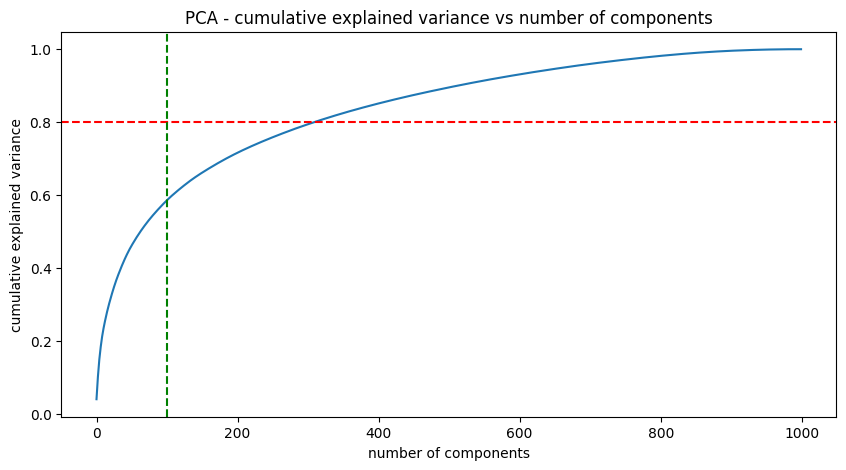

In [282]:
# Explained variance for different number of components
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y= 0.8, color='red', linestyle='--')
plt.axvline(x= 100, color='green', linestyle='--')
plt.show()

- We find that 100% of the variance is explained by about ~200 components.
- Also, more than 80% of the variance is explained just by 100 components.
- Hence to simplify the model, and reduce dimensionality, we can take the top 100 components, which will still be able to capture more than 80% of variance.

In [241]:
# reducing the dimensions to 100 using pca
pca = PCA(n_components=100, random_state=42)
pca.fit(train_vector)

PCA(n_components=100, random_state=42)

In [242]:
# transformed features
train_vector = pca.transform(train_vector)
test_vector  = pca.transform(test_vector)
# shape of transformed vectors
print(train_vector.shape)
print(test_vector.shape)

(42988, 100)
(10747, 100)


In [243]:
# Get the vectorized X_train data
X_train = np.concatenate((X_train, train_vector), axis=1)

#Get the vectorized X_test data
X_test = np.concatenate((X_test, test_vector),axis=1)

In [244]:
# converting them to pandas dataframe for checking null values
X_train = pd.DataFrame(X_train)

In [245]:
X_test = pd.DataFrame(X_test)

In [246]:
X_train.head(1)

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,upi payment ph ibl kotak mahindra ybl13128083f...,-207.0,11,-0.023542,0.043636,0.013568,-0.053541,0.053709,-0.022094,0.170373,...,0.073999,0.051637,-0.044663,0.033324,-0.041644,0.005188,0.016333,0.03916,-0.023924,0.006905


In [247]:
# We need to remove first text column from X_train and X_test
X_train.drop([0],axis = 1,inplace=True)
X_test.drop([0],axis=1,inplace=True)

In [248]:
# We need to feature scale column 1 and column 2
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[[1,2]] = scaler.fit_transform(X_train[[1,2]])
X_test[[1,2]] = scaler.transform(X_test[[1,2]])
X_test = X_test.values

In [249]:
unique_values, counts = np.unique(y_train, return_counts=True)

# Print the value counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 10441
1: 18
2: 9
3: 138
4: 4
5: 5
6: 46
7: 28
8: 387
9: 258
10: 178
11: 6351
12: 2635
13: 4
14: 9
15: 114
16: 154
17: 62
18: 53
19: 327
20: 1943
21: 10
22: 999
23: 472
24: 992
25: 26
26: 376
27: 18
28: 14387
29: 1051
30: 23
31: 9
32: 649
33: 13
34: 6
35: 9
36: 267
37: 10
38: 7
39: 12
40: 283
41: 14
42: 9
43: 78
44: 3
45: 22
46: 38
47: 20
48: 21


In [250]:
# Making the training dataset to handle imbalancing in the data
training_data = pd.DataFrame(np.concatenate((X_train.values,y_train.reshape(-1,1)),axis=1))

In [251]:
training_data.rename(columns={102: 'Labels'}, inplace=True)

In [252]:
class_counts = training_data['Labels'].value_counts()
classes_to_undersample = class_counts[class_counts > 877].index
undersampled_df = pd.DataFrame()

for class_label in classes_to_undersample:
    class_data = training_data[training_data['Labels'] == class_label].sample(877, random_state=42)
    undersampled_df = pd.concat([undersampled_df, class_data])



In [253]:


# Identify the value counts of each class
class_counts = training_data['Labels'].value_counts()

# Identify the classes that have less than 877 rows
classes_to_oversample = class_counts[class_counts < 877].index

# Create an empty DataFrame to store the oversampled data
data_to_oversample = pd.DataFrame()

for class_label in classes_to_oversample:
    class_data = training_data[training_data['Labels'] == class_label]
    data_to_oversample = pd.concat([data_to_oversample, class_data])



In [254]:
training_data = pd.DataFrame(np.concatenate((data_to_oversample.values,undersampled_df.values),axis= 0))

In [255]:
training_data.rename(columns={102: 'Labels'}, inplace=True)
training_data['Labels'] = training_data['Labels'].astype(int)

In [256]:
training_data = training_data.drop_duplicates()

In [257]:
training_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,Labels
0,0.454507,0.34375,-0.067722,0.034164,0.032748,-0.013637,0.019901,-0.036021,0.107314,0.077162,...,0.001238,0.019813,-0.00047,0.011507,0.008323,-0.000233,-0.015761,0.006668,-0.006148,32


In [258]:


# Assuming your dataset is stored in a pandas DataFrame called 'df'
# And the column containing labels is named 'Labels'

# Count the occurrence of each label
label_counts = training_data['Labels'].value_counts()

# Get the labels with count <= 6
labels_to_augment = label_counts[label_counts <= 6].index

# Initialize a new DataFrame to store the augmented data
augmented_data = pd.DataFrame()

# Iterate over the labels to augment
for label in labels_to_augment:
    # Get the rows with the current label
    label_data = training_data[training_data['Labels'] == label]

    # Calculate the number of samples needed to reach 10 rows
    num_samples_needed = 10 - label_data.shape[0]

    # Add noise to the existing rows and generate additional rows
    for _ in range(num_samples_needed):
        # Add random noise to the features of the row
        noisy_row = label_data.iloc[0, :-1] + np.random.normal(0, 0.0009, size=label_data.shape[1]-1)

        # Create a new DataFrame row with the noisy features and the original label
        augmented_row = pd.DataFrame([np.append(noisy_row, label)], columns=training_data.columns)

        # Append the augmented row to the augmented_data DataFrame
        augmented_data = augmented_data.append(augmented_row, ignore_index=True)

# Concatenate the original DataFrame with the augmented data
training_data = pd.concat([training_data, augmented_data], ignore_index=True)


# Synthetic Minority Oversampling Technique (SMOTE)

This technique generates synthetic data for the minority class.

SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

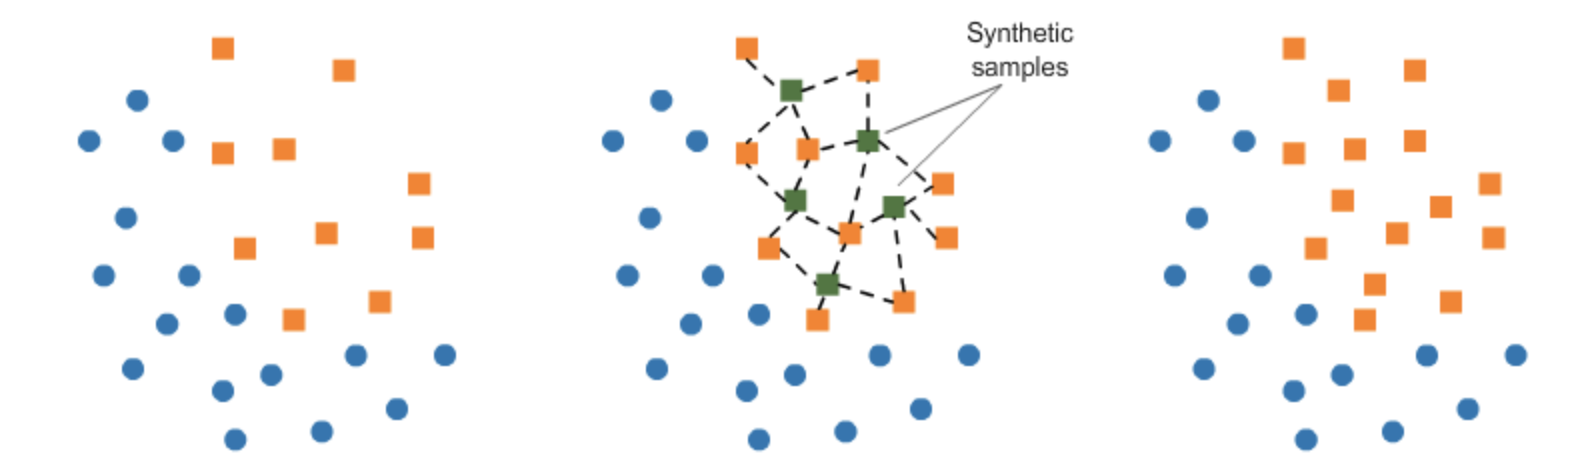

In [259]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(k_neighbors=5)

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(training_data.iloc[:,0:-1], training_data['Labels'])


In [260]:
final_data = pd.DataFrame(np.concatenate((x_smote.values,np.array(y_smote).reshape(-1,1)),axis=1))

In [261]:
final_data.rename(columns={102: 'Labels'}, inplace=True)
final_data['Labels'] = final_data['Labels'].astype(int)
final_data

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,Labels
0,0.454507,0.34375,-0.067722,0.034164,0.032748,-0.013637,0.019901,-0.036021,0.107314,0.077162,...,0.001238,0.019813,-0.00047,0.011507,0.008323,-0.000233,-0.015761,0.006668,-0.006148,32
1,0.454522,0.1875,0.097531,-0.020984,-0.038074,-0.104563,-0.053118,-0.022017,0.030539,-0.011558,...,0.053267,0.037735,-0.004823,-0.0322,0.053796,0.044674,-0.027488,0.067239,-0.045079,32
2,0.454425,0.375,-0.278737,0.422485,-0.019666,-0.003223,-0.102483,0.096752,-0.0576,0.058649,...,0.01997,0.106953,0.075257,-0.045014,-0.039104,-0.013276,-0.019655,0.038407,-0.057595,32
3,0.454483,0.21875,0.126925,0.008684,-0.01162,-0.165241,-0.016122,-0.028101,0.029883,0.017565,...,-0.164922,0.005432,0.022336,-0.029131,-0.027762,-0.009636,0.064875,0.095729,-0.036255,32
4,0.452479,0.375,-0.020569,-0.096976,-0.062999,0.048852,-0.104219,-0.064874,0.029184,-0.017186,...,-0.01876,0.005178,-0.014037,0.024732,-0.002657,-0.001325,0.007118,-0.030368,0.030177,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41302,0.454474,0.28125,0.044509,-0.071893,-0.076178,-0.034649,-0.092305,0.036383,0.056704,-0.01933,...,0.054847,0.00168,-0.028309,0.017378,0.027187,0.09149,-0.004995,0.0617,-0.011629,48
41303,0.454516,0.40625,-0.046262,-0.079403,-0.073218,0.052213,-0.08292,0.108441,0.22307,-0.027106,...,-0.003358,-0.007005,-0.009988,-0.013729,-0.118267,0.092129,-0.031554,-0.068243,-0.141033,48
41304,0.454487,0.3125,0.045455,-0.06399,-0.093048,-0.016372,-0.020531,0.054755,0.04004,0.055283,...,0.03998,-0.022746,-0.007272,-0.029309,0.01152,-0.021512,-0.001764,0.008812,-0.001163,48
41305,0.45449,0.3125,0.045455,-0.06399,-0.093048,-0.016372,-0.020531,0.054755,0.04004,0.055283,...,0.03998,-0.022746,-0.007272,-0.029309,0.01152,-0.021512,-0.001764,0.008812,-0.001163,48


In [262]:
X_train = final_data.iloc[:,:-1].values
y_train = final_data['Labels'].values



### **Model Training**

In [263]:

# empty list for appeding performnace metric score
model_result = []

def predict(ml_model, model_name):

  '''
  Pass the model and predict value.
  Function will calculate all the eveluation metrics and appending those metrics score on model_result table.
  Plotting confusion_matrix and roc_curve for test data.
  '''

  # model fitting
  model = ml_model.fit(X_train, y_train)

  # predicting value and probability
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  y_train_prob = model.predict_proba(X_train)[:,1]
  y_test_prob = model.predict_proba(X_test)[:,1]


  ''' Performance Metrics '''
  # accuracy score  ---->  TP+TN/TP+FP+TN+FN
  train_accuracy = accuracy_score(y_train, y_train_pred)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print(f'train accuracy : {round(train_accuracy,3)}')
  print(f'test accuracy : {round(test_accuracy,3)}')

  # precision score  ---->  TP/TP+FP
  train_precision = precision_score(y_train, y_train_pred)
  test_precision = precision_score(y_test, y_test_pred)
  print(f'train precision : {round(train_precision,3)}')
  print(f'test precision : {round(test_precision,3)}')

  # recall score  ---->  TP/TP+FN
  train_recall = recall_score(y_train, y_train_pred)
  test_recall = recall_score(y_test, y_test_pred)
  print(f'train recall : {round(train_recall,3)}')
  print(f'test recall : {round(test_recall,3)}')

  # f1 score  ---->  Harmonic Mean of Precision and Recall
  train_f1 = f1_score(y_train, y_train_pred)
  test_f1 = f1_score(y_test, y_test_pred)
  print(f'train f1 : {round(train_f1,3)}')
  print(f'test f1 : {round(test_f1,3)}')

  # roc_auc score  ---->  It tells how much the model is capable of distinguishing between classes.
  train_roc_auc = roc_auc_score(y_train, y_train_prob)
  test_roc_auc = roc_auc_score(y_test, y_test_prob)
  print(f'train roc_auc : {round(train_roc_auc,3)}')
  print(f'test roc_auc : {round(test_roc_auc,3)}')
  print('-'*80)

  # classificatio report
  print(f'classification report for test data \n{classification_report(y_test, y_test_pred)}')
  print('-'*80)


  ''' plotting Confusion Matrix '''
  ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
  plt.title('confusion matrix on Test data', weight='bold')
  plt.show()
  print('-'*80)


  ''' plotting ROC curve '''
  fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
  plt.plot(fpr,tpr, label=f'ROC - {model_name}')
  plt.plot([0,1], [0,1], '--')
  plt.title('ROC curve on Test data', weight='bold')
  plt.xlabel('False Positive Rate----->')
  plt.ylabel('True Positive Rate----->')
  plt.legend(loc=4)


  ''' actual value vs predicted value on test data'''
  d = {'y_actual':y_test, 'y_predict':y_test_pred}
  print(pd.DataFrame(data=d).head(10).T) # creating dataframe including actual value and predicted value
  print('-'*80)


  # appneding performance metrics score to make final model_result.
  model_result.append({'model':model_name,
                       'train_accuracy':train_accuracy,
                       'test_accuracy':test_accuracy,
                       'train_precision':train_precision,
                       'test_precision':test_precision,
                       'train_recall':train_recall,
                       'test_recall':test_recall,
                       'train_f1':train_f1,
                       'test_f1':test_f1,
                       'train_roc_auc':train_roc_auc,
                       'test_roc_auc':test_roc_auc})



#### **XGBoost**


The XGBoost can be used to solve for regression or classification problems.

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting.


In [264]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


num_classes = len(np.unique(y_train))

# Create an XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_classes=num_classes)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")



[10:29:58] WARNING: ../src/learner.cc:767: 
Parameters: { "num_classes" } are not used.

Accuracy: 0.8132502093607519
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      2610
           1       0.67      0.40      0.50         5
           2       1.00      1.00      1.00         2
           3       0.67      0.94      0.78        34
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.47      0.73      0.57        11
           7       0.12      0.57      0.21         7
           8       0.51      0.90      0.65        97
           9       0.25      0.65      0.36        65
          10       0.28      0.75      0.40        44
          11       0.87      0.80      0.83      1588
          12       1.00      0.99      0.99       658
          13       0.09      1.00      0.17         1
          14       1.00      1.00      1.00     

In [265]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Assuming your XGBoost model is called 'model'
# Assuming your test data is 'X_test' and the corresponding true labels are 'y_test'

# Predict probabilities for each class
probs = model.predict_proba(X_test)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, probs, multi_class='ovr')

print("ROC-AUC Score: {:.4f}".format(roc_auc))


ROC-AUC Score: 0.9579


## **Building the final user friendly Predictor using saving the modesl and then using for Prediction**

In [266]:
import pickle

In [267]:
with open('xgboost_pickle.pkl','wb') as file:
  pickle.dump(model,file)

In [268]:
with open('min_max_scaler.pkl','wb') as file:
  pickle.dump(scaler,file)

In [269]:
with open('tfidf.pkl','wb') as file:
  pickle.dump(tfidf,file)

In [270]:
with open('pca.pkl','wb') as file:
  pickle.dump(pca,file)

In [271]:
import re
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import numpy as np
import pickle
import math
# download the stop words list if it is not already downloaded
nltk.download('stopwords')

# create a set of English stop words
stop_words = stopwords.words('english')

# displaying stopwords
np.array(stop_words)


# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

def stopwords(text):
    '''a function for removing the stopword and lowercase the each word'''
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    # joining the list of words with space separator
    return " ".join(text)

# First lets clean the Textual Data
def clean_sentence(sentence):
    delimiters =  re.escape(string.punctuation)
    string_to_split = sentence
    result = re.findall(r'\b(?!\d+\b)\w+\b|' + delimiters, string_to_split)
    return " ".join([s for s in result if not re.match(delimiters, s)])


#lets work on user input data
def custom_user_input(input):
  txn_amt = int(input[6])
  txn_amt = -txn_amt if txn_amt > 0 else txn_amt

  desc =input[3]
  add_desc = input[7] if input[7]!= float('nan') else ''

  description = clean_sentence(desc + add_desc)
  description = stemming(stopwords(description))
  count = len(description)
  with open('min_max_scaler.pkl','rb') as file:
    scaler = pickle.load(file)
  feature = scaler.transform(np.array([txn_amt,count]).reshape(1,2))
  with open('tfidf.pkl','rb') as file:
    tfidf = pickle.load(file)

  description = np.array(description).reshape((1,))
  tokenize = tfidf.transform(description).toarray()
  with open('pca.pkl','rb') as file:
    pca = pickle.load(file)
  vector = pca.transform(tokenize)
  cleaned_input = np.concatenate((feature,vector),axis=1)
  return cleaned_input






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Testing the inpput

In [272]:
test_input

array([46.0, datetime.datetime(2021, 10, 8, 0, 0), nan,
       'TO TRANSFER-UPI/DR/128188085567/HOTEL AK/UTIB/gpay-11182/Payme- (Ref# TRANSFER TO 4692605162091)',
       'Accomodations', 'Travel', -1321.0, 'Transfer to GPAY-11182',
       12066.36], dtype=object)

In [273]:
# testing the input
with open('xgboost_pickle.pkl','rb') as file:
  model = pickle.load(file)
prediction = model.predict(custom_user_input(list(test_input)))
category, subcategory = reference[reference['Code']== prediction[0]].Label.values[0].split('::')
print(f"The category is '{category}' and subcategory is '{subcategory}' ")

The category is 'Travel' and subcategory is 'Accomodations' 


In this project, we worked on a Classification  problem wherein we had to classifythe Transactions on the basis of **Description** , **Additional Desc** and **Amount of Transaction**
- The dataset contained about 53,000 records, and 8 attributes.
We began by dealing with the dataset's missing values and doing exploratory data analysis (EDA).
- Among top 5 Categories, transaction with **Payment Category** has highest frequency.

- Percentage of **Payments Category** take **44.6 % of txns**, **Shopping** takes lowest **3.1% **of all txns
- It was decided to **merge the columns Description and Category.1**. Here Category.1 is regareded as Additional description. And apply NLP on those merge columns. The values in these attributes were tokenized, preprocessed, and then vectorized using TFIDF vectorizer.
- I created the target varaible using merging of**"Category"** and **"SubCategory "** columns.
- Through **TFIDF Vectorization, we created a total of 200 attributes**.
- We used **Principal Component Analysis (PCA) to handle the curse of dimensionality**. **100 components were able to capture more than 80% of variance**, and hence, the number of components were restricted to 100.
- I have decided to train the model using **XGBoost Classifier**
- The model seems to performed well with the **accuracy of 81**%. The **precision score of 0.87** and recall score was **0.81**.
- A flask based web App is made. You can use it to get you transaction related query resolved .Thanks !!!!!!!

# **ATTENTION**
Below Part can only be executed using TPU, even it's one epoch leads to session crash in google colab.
## Google colab RAM capicity is 12 GB. Which is easily crossed by below operation.


In [284]:
#internitally failing the program
raise Exception

## **DistilBERT model**
DistilBERT is a compact version of the BERT (Bidirectional Encoder Representations from Transformers) model, designed to be faster and more memory-efficient while still preserving most of the performance of the original BERT model. It achieves this by using a smaller architecture with fewer layers and reduced hidden size.

Multi-class classification refers to the task of classifying input data into multiple classes, where each data point can be assigned to one and only one class. In the context of DistilBERT, multi-class classification involves using the model to predict the correct class label for a given input, when there are multiple possible classes to choose from.

In [ ]:
# we have a dataset ready for bert model
data_bert

In [ ]:
from sklearn.utils import resample

# Calculate the value counts of the 'Labels' column
label_counts = data_bert['Encoded_Target'].value_counts()

# Get the labels with value counts equal to 1
labels_to_oversample = label_counts[label_counts <= 3].index

# Oversample the rows with those labels
oversampled_data = pd.DataFrame()
for label in labels_to_oversample:
    label_data = data_bert[data_bert['Encoded_Target'] == label]
    oversampled_samples = resample(label_data, n_samples=10, random_state=42)
    oversampled_data = pd.concat([oversampled_data, oversampled_samples])

# Concatenate the oversampled data with the original data
data_bert = pd.concat([data_bert, oversampled_data],ignore_index = True)

In [ ]:
#lets split the data to train and test
X,y = data_bert.iloc[:,:-1].values,data_bert.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify= y,test_size=0.2,random_state=42)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Convert the input data to string format
X_train_str = X_train[:, 0].astype(str)
X_test_str = X_test[:, 0].astype(str)

# Tokenize the input data
train_encodings = tokenizer(X_train_str.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test_str.tolist(), truncation=True, padding=True)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))


## **Fine Tuning with TF-trainer class**

In [ ]:


training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Decreased the number of training epochs to 1
    per_device_train_batch_size=1000,  # Increased the training batch size to 400
    per_device_eval_batch_size=800,
    warmup_steps=100,  # Decreased the number of warm-up steps to 200
    weight_decay=0,  # Set weight decay to 0 (disabled)
    logging_dir='./logs',
    eval_steps=2000  # Increased the number of steps before evaluation to 2000
)


with training_args.strategy.scope():
  trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels= len(np.unique(y_train)))

In [ ]:
trainer = TFTrainer(model=trainer_model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset)


In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

## Saving and loading the model

In [ ]:
save_dir = '/saved_model'
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

In [ ]:
#loading the pretrained model
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_dir)
model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_dir)


In [ ]:
# lets test the text
